In [15]:
# To be used as parameters to `butler.query_datasets`
dataset_names = ["dia_source",
                 "dia_object",
                 "dia_object_forced_source",
                 "object_forced_source",
                 "source2",
                 "object",
                ]

In [16]:
import lsst.daf.butler as dafButler

repo = '/repo/main'
instrument = "LSSTComCam"
butler_11 = dafButler.Butler(repo, collections='LSSTComCam/runs/DRP/DP1/w_2025_11/DM-49472', instrument=instrument)
# butler_12 = dafButler.Butler(repo, collections='LSSTComCam/runs/DRP/DP1/d_2025_03_25/DM-49693', instrument=instrument)
# butler_13 = dafButler.Butler(repo, collections='LSSTComCam/runs/DRP/DP1/w_2025_13/DM-49751', instrument=instrument)
butler_14 = dafButler.Butler(repo, collections='LSSTComCam/runs/DRP/DP1/w_2025_14/DM-49864', instrument=instrument)
# test_11 = butler_11.getURI('object_forced_source', dataId={'skymap':'lsst_cells_v1', 'tract': 10704, 'patch': 22})
# test_12 = butler_11.getURI('object_forced_source', dataId={'skymap':'lsst_cells_v1', 'tract': 10704, 'patch': 22})
# test_13 = butler_13.getURI('object_forced_source', dataId={'skymap':'lsst_cells_v1', 'tract': 10704, 'patch': 22})
test_14 = butler_14.getURI('object_forced_source', dataId={'skymap':'lsst_cells_v1', 'tract': 10704, 'patch': 22})

# Choose one
butler = butler_14

In [17]:
[len(butler.query_datasets(d)) for d in dataset_names]

[25, 25, 596, 635, 1786, 29]

In [43]:
import numpy as np
from tqdm import tqdm

# How to work through object refs
# List of tract indices to process
d_name = dataset_names[3]
print(d_name)
obj_refs = butler.query_datasets(d_name)
tract_indices = np.arange(0, len(obj_refs))

# Loop through the specified tracts and fetch the data
dia_objs = []
for idx in tqdm(tract_indices):
    obj_ref = obj_refs[idx]  # Select the corresponding obj_ref
    try:
        # was: 'dia_object' literal
        dia_obj_uri = butler.getURI(d_name, dataId=obj_ref.dataId)
        dia_objs.append(str(dia_obj_uri)[7:])
    except Exception as ex:
        print(f"Cannot get {obj_ref.dataId} because {ex}")
print(f"Retrieved {len(dia_objs)} objects out of {len(tract_indices)} tracts")

object_forced_source


100%|██████████| 635/635 [00:45<00:00, 13.95it/s]

Retrieved 635 objects out of 635 tracts


Text(0, 0.5, 'Parquet file size (MiB)')

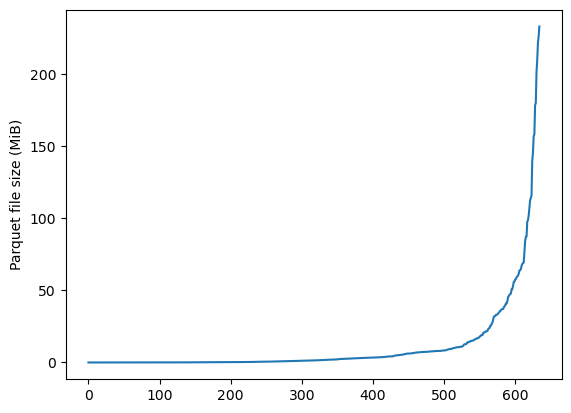

In [44]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.plot(np.sort([os.path.getsize(d) / 1024**2 for d in dia_objs]))
plt.ylabel("Parquet file size (MiB)")

In [45]:
%cd ~/rubin-user

/sdf/data/rubin/user/dtj1s


In [46]:
import time
import pyarrow
import pyarrow.parquet as pq
import pandas as pd

# I want to have these sorted by largest, but I don't have that data
parquet_file_name = dia_objs[-5]
# table = pq.read_table(parquet_file_name)
compression_settings = [
    ('SNAPPY', None),
    ('ZSTD', 1),
    ('ZSTD', 3),
    ('ZSTD', 6),
    ('ZSTD', 9),
    ('ZSTD', 15),
    ('ZSTD', 22),
]

def find_compression_wins(table: pyarrow.lib.Table, output_dir: str = ".") -> pd.DataFrame:
    results = []
    
    for codec, level in compression_settings:
        filename = f"{output_dir}/sample_{codec.lower()}"
        if level is not None:
            filename += f"_{codec}_lvl{level}"
        filename += ".parquet"
        
        # Write
        start_write = time.time()
        pq.write_table(
            table,
            filename,
            compression=codec,
            compression_level=level
        )
        write_time = time.time() - start_write
        
        start_read = time.time()
        _ = pq.read_table(filename)
        read_time = time.time() - start_read
    
        file_size = os.path.getsize(filename) / 1024**2  # MiB
    
        results.append({
            'Compression': codec,
            'Level': level if level is not None else '-',
            'File Size (MiB)': round(file_size, 1),
            'Write Time (s)': round(write_time, 4),
            'Read Time (s)': round(read_time, 4),
            'File': filename
        })
    
    results_df = pd.DataFrame(results)
    results_df.sort_values(by='File Size (MiB)', inplace=True)
    results_df.reset_index(drop=True, inplace=True)
    
    snappy = results_df[results_df['Compression'] == 'SNAPPY'].iloc[0]
    results_df['Size Win'] = snappy['File Size (MiB)'] / results_df['File Size (MiB)'] - 1
    results_df['Time Win'] = snappy['Read Time (s)'] / results_df['Read Time (s)'] - 1
    return results_df

find_compression_wins(pq.read_table(parquet_file_name))

,Compression,Level,File Size (MiB),Write Time (s),Read Time (s),File,Size Win,Time Win
0,SNAPPY,-,0.1,0.0099,0.0053,./sample_snappy.parquet,0.0,0.000000
1,ZSTD,1,0.1,0.0068,0.0034,./sample_zstd_ZSTD_lvl1.parquet,0.0,0.558824
2,ZSTD,3,0.1,0.0067,0.0031,./sample_zstd_ZSTD_lvl3.parquet,0.0,0.709677
3,ZSTD,6,0.1,0.0077,0.0032,./sample_zstd_ZSTD_lvl6.parquet,0.0,0.656250
4,ZSTD,9,0.1,0.0073,0.0032,./sample_zstd_ZSTD_lvl9.parquet,0.0,0.656250
5,ZSTD,15,0.1,0.0116,0.0033,./sample_zstd_ZSTD_lvl15.parquet,0.0,0.606061
6,ZSTD,22,0.1,0.0159,0.0036,./sample_zstd_ZSTD_lvl22.parquet,0.0,0.472222


In [47]:
import os
import time
import pandas as pd
import pyarrow.parquet as pq

compression_settings = [
    # ('SNAPPY', None),
    # ('ZSTD', 1),
    # ('ZSTD', 3),
    # ('ZSTD', 6),
    # ('ZSTD', 9),
    ('ZSTD', 15),
    # ('ZSTD', 22),
]

def survey_parquet_files(parquet_file_paths, output_dir="."):
    survey_results = []

    for file_path in tqdm(parquet_file_paths):
        # print(f"Processing: {file_path}")
        table = pq.read_table(file_path)

        # Original file stats
        original_size = os.path.getsize(file_path) / 1024**2  # MiB
        start_read = time.time()
        _ = pq.read_table(file_path)
        original_read_time = time.time() - start_read

        results = []
        for codec, level in compression_settings:
            filename = os.path.join(output_dir, f"{os.path.basename(file_path)}_{codec.lower()}")
            if level is not None:
                filename += f"_lvl{level}"
            filename += ".parquet"

            # Write
            start_write = time.time()
            pq.write_table(table, filename, compression=codec, compression_level=level)
            write_time = time.time() - start_write

            # Read
            start_read = time.time()
            _ = pq.read_table(filename)
            read_time = time.time() - start_read

            # File stats
            file_size = os.path.getsize(filename) / 1024**2  # MiB

            results.append({
                # 'Source File': file_path,
                # 'Compression': codec,
                # 'Level': level if level is not None else '-',
                'Original Size (MiB)': round(original_size, 2),
                'New Size (MiB)': round(file_size, 2),
                # 'Write Time (s)': round(write_time, 4),
                'Original Read Time (s)': round(original_read_time, 2),
                'Read Time (s)': round(read_time, 4),
                # 'File': filename,
                'Size Win': round(original_size / file_size - 1, 2),
                'Time Win': round(original_read_time / read_time - 1, 2),
            })

        df = pd.DataFrame(results)
        # TODO: need to sort?
        df.sort_values(by='New Size (MiB)', inplace=True)
        df.reset_index(drop=True, inplace=True)

        survey_results.append(df)

    return pd.concat(survey_results, ignore_index=True)
survey = survey_parquet_files(dia_objs)
survey

100%|██████████| 635/635 [08:26<00:00,  1.25it/s]


,Original Size (MiB),New Size (MiB),Original Read Time (s),Read Time (s),Size Win,Time Win
0,0.07,0.05,0.00,0.0035,0.28,-0.04
1,0.03,0.02,0.00,0.0034,0.25,0.00
2,8.37,6.41,0.02,0.0297,0.31,-0.48
3,7.97,6.19,0.02,0.0154,0.29,0.03
4,4.12,3.10,0.01,0.0109,0.33,0.02
...,...,...,...,...,...,...
630,0.07,0.06,0.00,0.0035,0.22,-0.10
631,0.13,0.10,0.00,0.0040,0.24,-0.10
632,0.39,0.31,0.00,0.0064,0.25,-0.25
633,0.92,0.74,0.00,0.0082,0.24,-0.42


In [48]:
survey[['Size Win', 'Time Win']].mean()

Size Win    0.271276
Time Win   -0.038268
dtype: float64

In [49]:
survey.sort_values(by='New Size (MiB)')

,Original Size (MiB),New Size (MiB),Original Read Time (s),Read Time (s),Size Win,Time Win
614,0.01,0.01,0.00,0.0039,0.13,-0.22
606,0.01,0.01,0.00,0.0054,0.17,-0.09
44,0.01,0.01,0.00,0.0028,0.13,-0.07
375,0.02,0.01,0.00,0.0032,0.18,0.02
372,0.01,0.01,0.00,0.0040,0.13,-0.06
...,...,...,...,...,...,...
265,201.18,148.01,0.55,0.4733,0.36,0.16
364,209.67,154.10,0.55,0.5323,0.36,0.03
48,221.58,163.70,0.44,0.4604,0.35,-0.05
323,226.20,166.68,0.56,0.3409,0.36,0.65


In [50]:
(survey['Original Size (MiB)'] - survey['New Size (MiB)']).sum()

np.float64(1866.1000000000001)

In [51]:
survey['Original Size (MiB)'].sum(), survey['New Size (MiB)'].sum()

(np.float64(7123.56), np.float64(5257.459999999999))

In [52]:
survey['Original Read Time (s)'].sum(), survey['Read Time (s)'].sum()

(np.float64(15.77), np.float64(15.948600000000003))